In [9]:
import xport
with open('C:/Users/Anjin/Downloads/LLCP2018.XPT', 'rb') as f:
    df = xport.to_dataframe(f)

In [11]:
#https://www.cdc.gov/brfss/annual_data/annual_2018.html
df.shape

(437436, 275)

In [14]:
df['GENHLTH'].unique()
df['PERSDOC2'].unique()

array([ 1.,  2.,  3.,  7.,  9., nan])

In [219]:
df_1=df[['GENHLTH','SLEPTIM1']]
df_1=df_1.dropna()
df_1=df_1[~((df_1['GENHLTH']==7)|(df_1['GENHLTH']==9))]
df_1=df_1[~((df_1['SLEPTIM1']==77)|(df_1['SLEPTIM1']==99))]

0.000000000000000


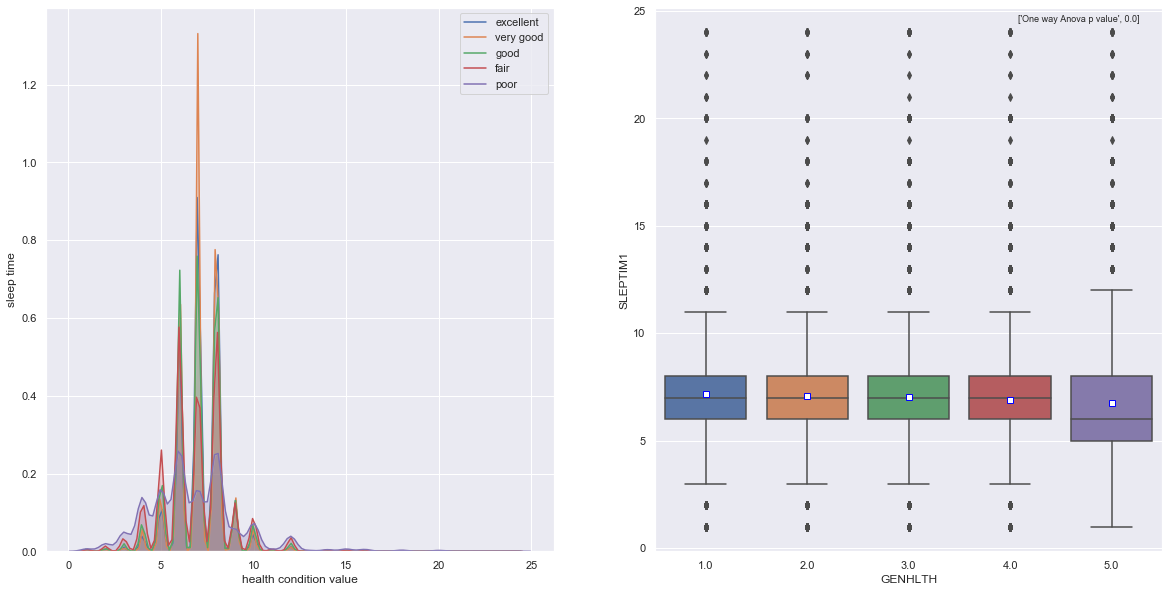

In [228]:
import seaborn as sns
fig, ax =plt.subplots(1,2)
sns.kdeplot(df_1[df_1['GENHLTH']==1]['SLEPTIM1'],label='excellent', shade=True,ax=ax[0])
sns.kdeplot(df_1[df_1['GENHLTH']==2]['SLEPTIM1'],label='very good', shade=True,ax=ax[0])
sns.kdeplot(df_1[df_1['GENHLTH']==3]['SLEPTIM1'],label='good', shade=True,ax=ax[0])
sns.kdeplot(df_1[df_1['GENHLTH']==4]['SLEPTIM1'],label='fair', shade=True,ax=ax[0])
sns.kdeplot(df_1[df_1['GENHLTH']==5]['SLEPTIM1'],label='poor', shade=True,ax=ax[0])
ax[0].set(xlabel='health condition value', ylabel='sleep time')
from scipy import stats

sns.boxplot(x='GENHLTH', y='SLEPTIM1', data=df_1,showmeans=True, ax=ax[1],
            meanprops={"marker":"s","markerfacecolor":"white", "markeredgecolor":"blue"})
F, p = stats.f_oneway(df_1[df_1['GENHLTH']==1]['SLEPTIM1'], 
                     df_1[df_1['GENHLTH']==2]['SLEPTIM1'], 
                     df_1[df_1['GENHLTH']==3]['SLEPTIM1'],
                     df_1[df_1['GENHLTH']==4]['SLEPTIM1'],
                     df_1[df_1['GENHLTH']==5]['SLEPTIM1'])
print('%.15f' % p)
fig.text(0.8, 0.86,['One way Anova p value',p], fontsize=9) 
sns.set(rc={'figure.figsize':(20,10)})

it shows that the general health condition (i.e. 5 different conditions: excellent very good, good, fair and poor) is related to one of the life style factor, how many hours a person sleeps every night. It appears, people with bad health conditions sleep less (To be noted, this is correlation not causality). One way ANOVA also says people with different health conditions has different sleep time. 

In [204]:
df_2=df[['HLTHPLN1', #health coverage
         'PERSDOC2', #Multiple Health Care Professionals
         'MEDCOST', #Could Not See Doctor Because of Cost
         'EXERANY2', #Exercise in Past 30 Days
         'SLEPTIM1', #How Much Time Do You Sleep
         'MARITAL',#Marital Status
         'EDUCA',#: Education Level
         'RENTHOM1',#Own or Rent Home
         'VETERAN3',#Are You A Veteran
         'EMPLOY1',#Employment Status
          'GENHLTH']].dropna()
df_2=df_2[~((df_2['GENHLTH']==7)|(df_2['GENHLTH']==9))]
df_2=df_2[~((df_2['MEDCOST']==7)|(df_2['MEDCOST']==9))]
df_2=df_2[~((df_2['PERSDOC2']==7)|(df_2['PERSDOC2']==9))]
df_2=df_2[~((df_2['SLEPTIM1']==77)|(df_2['SLEPTIM1']==99))]
df_health=df_2['GENHLTH']
df_2.drop(['GENHLTH'], inplace=True, axis=1)

In [205]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_2, df_health, test_size=0.33, random_state=42)


In [207]:

import lightgbm as lgb
from sklearn.metrics import r2_score
lgb_params = {
              'feature_fraction': 0.5,
               'metric': 'rmse',#'binary_logloss',#
               'nthread':10, 
               'min_data_in_leaf': 2**7, 
               'bagging_fraction': 1, 
               'learning_rate': 0.1, 
               'objective': 'mse', 
               'bagging_seed': 2**7, 
               'num_leaves': 2**7,
               'bagging_freq':1,
               'verbose':0 
              }

model = lgb.train(lgb_params, lgb.Dataset(X_train, label=y_train))
pred_lgb = model.predict(X_test).clip(0,20)

print('Test R-squared for LightGBM is %f' % r2_score(y_test, pred_lgb))


Test R-squared for LightGBM is 0.259115


[Text(0, 0.5, 'frequency'),
 Text(0.5, 0, 'health condition value absolute error')]

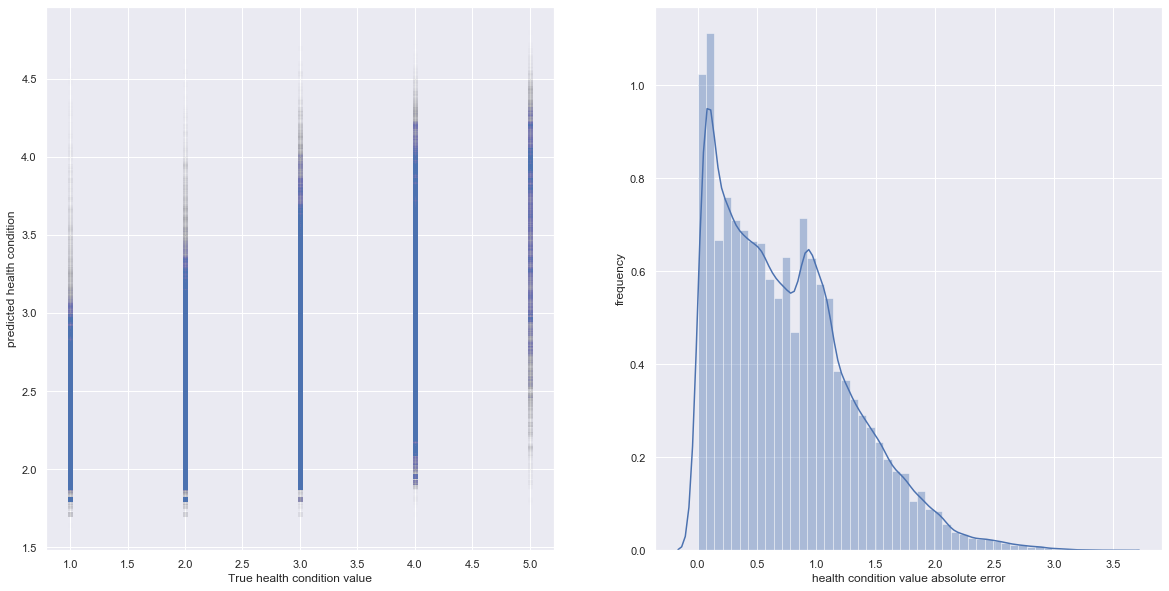

In [227]:
fig, ax =plt.subplots(1,2)

sns.scatterplot(y_test, pred_lgb,alpha=0.002,ax=ax[0])
ax[0].set(xlabel='True health condition value', ylabel='predicted health condition')
sns.distplot(abs(y_test- pred_lgb),ax=ax[1])
ax[1].set(xlabel='health condition value absolute error', ylabel='frequency')

I handpicked 10 factors and train a simple tree based lightGBM model. The result shows this model can predict the health conditions better than random guess. Most error is within one health condition difference.